In [1]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt

import tensorflow_hub as hub

from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

%matplotlib inline

In [15]:
# This Cell is for Image Preprocessing and bounding boxes

def download_resize_img(url, width = 256, height = 256):
    _, filename = tempfile.mkstemp(suffix=".jpg")
    resp = urlopen(url)

    img = resp.read()
    img = BytesIO(img) # To Add image to memory buffer

    image = Image.open(img)
    # To Crop and Preprocess Image with required size
    image = ImageOps.fit(image, (width, height), Image.ANTIALIAS) # This resize image and crop if aspect ratio is different from the given width and height
    image = image.convert("RGB")

    image.save(filename, format="JPEG", quality = 90)

    return filename, image

def draw_img_bbox(img, box_info, disp_class_names = ()):

    draw_img = ImageDraw.Draw(img)
    img_width, img_height = img.size
    
    left = box_info[0] * img_width
    right = box_info[1] * img_width
    down = box_info[2] * img_height
    up = box_info[3] * img_height
    color = box_info[4]

    font = ImageFont.load_default()
    thickness = 4

    draw_img.line([(left, up), (left, down), (right, down), (right, up), (left, up)], width = thickness, fill = color)

    disp_str_heights = [font.getsize(ds)[1] for ds in disp_class_names]
    total_disp_str_height = (1 + 2 * 0.05) * sum(disp_str_heights)

    if up > total_disp_str_height:
        text_bottom = up
    else:
        text_bottom = total_disp_str_height
    
    for display_str in disp_class_names[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw_img.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw_img.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes = 10, min_score = 0.1):
    num_boxes = min(max_boxes, boxes.shape[0]) # If there is more than max_boxes detect only max boxes, otherwise detect all
    colors = list(ImageColor.colormap.values())

    for i in range(num_boxes):
        if scores[i] >= min_score: # Detect Box
            y_min, x_min, y_max, x_max = tuple(boxes[i]) #Bounding Boxes

            color = colors[hash(class_names[i]) % len(colors)]
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                         int(100 * scores[i]))
            
            img = Image.fromarray(np.uint8(image)).convert("RGB")

            box = [x_min, x_max, y_min, y_max, color]

            draw_img_bbox(img, box, [display_str])
            np.copyto(image, np.array(img))

            return image

def load_img(path):
    # This function is to load image from path
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def display_img(img):
    figure = plt.figure(figsize=(20, 20))
    plt.grid(False)
    plt.imshow(img)



In [3]:
module_url = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
model = hub.load(module_url)
detector = model.signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [6]:
def predict(model, path):
    img = load_img(path)
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...] # As TensorFlow Models Accept Batch for inference
    prediction = model(converted_img)
    prediction = {key:value.numpy() for key,value in prediction.items()}
    img = draw_boxes(
      img.numpy(), prediction["detection_boxes"],
      prediction["detection_class_entities"], prediction["detection_scores"])
    return img


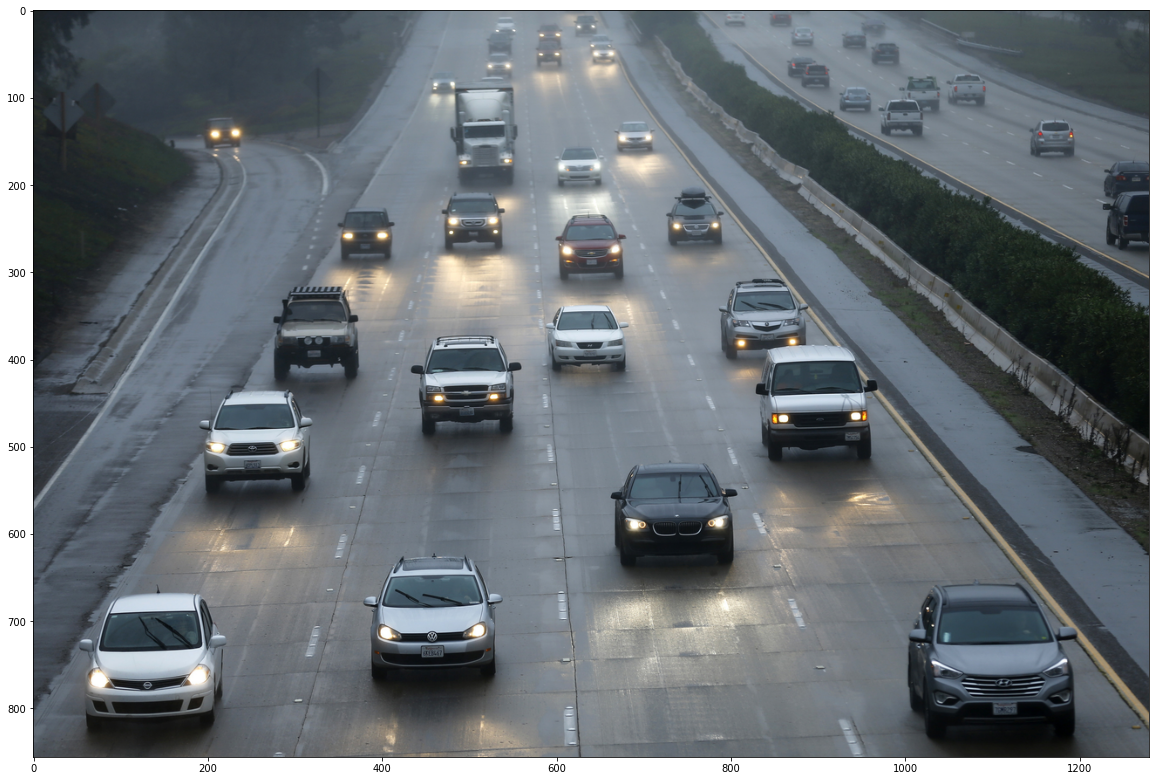

In [18]:
# Let's Inference:
url = "https://assets.weforum.org/article/image/xRpCRbXOdhQnvETWGnCiApGyPQBao9SJRHbnaDSxXfQ.jpg"
filename, img = download_resize_img(url, 1280, 856)
display_img(img)

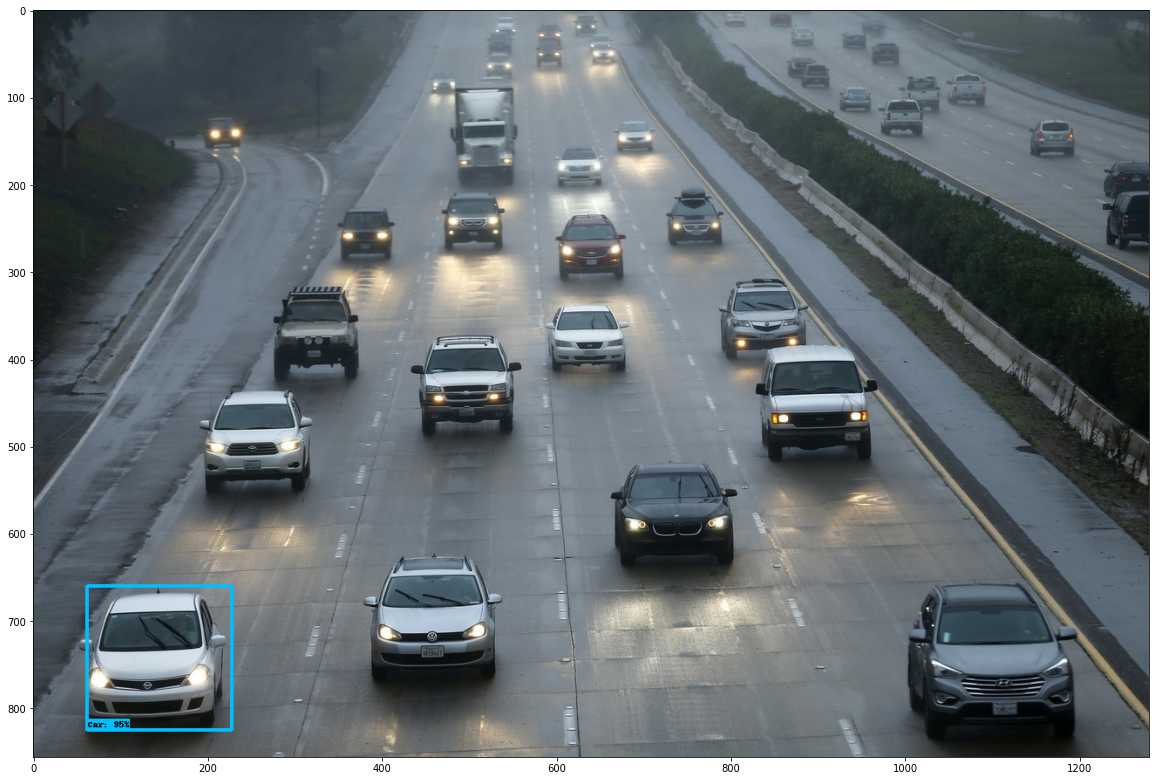

In [19]:
img_res = predict(detector, filename)
display_img(img_res)